In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('ticks')

Depenencies for using pyIDEAS/Biointense:
* Sympy
* Odespy ->  https://github.com/hplgit/odespy

## Respirometer model in pyIDEAS

The following respirometric model  for aerobic degradation of acetate without biomass storage will be used (Gernaey, 2002). It predicts the model output variable exogenous oxygen uptake rate of bacteria: $OUR_{ex}$ ($mg L^{-1} d^{-1}$).

$$\frac{dS}{dt} = -(1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1}{Y}\frac{S}{K_S + S}X$$
$$\frac{dX}{dt} = (1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1}{Y}\frac{S}{K_S + S}X-bX$$
$$OUR_{ex} = (1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1-Y}{Y}\frac{S}{S+k_S}X$$

with 

$S$: substrate concentration ($mgCOD\; L^{-1}$ ), <br>
$X$: biomass concentration ($mg COD\; L^{-1}$),<br>
$\tau$: retardation on biomass activity ($d^{-1}$ ), <br>
$Y$: yield of the biomass (-),<br>
$\mu_{max}$: maximum growth rate ($d^{-1}$), <br>
$K_s$: half-saturation Monod constant ($mg COD\; L^{-1}$) <br>
$\quad$(if $\mu$ equals half of $\mu_{max}$, the substrate $S$ equals $K_s$).

Reference: 

<small>Gernaey, K., Petersen, B., Nopens, I., Comeau Y. and P.A. Vanrolleghem, Modeling aerobic carbon source degradation processes using titrimetric data and combined respirometric-titrimetric data: experimental data and model structure, Biotechnology and bioengineering, 79(7), 741-753, 2002</small>

### Using the pyIDEAS modelling environment:

In [1]:
from biointense.model import Model
from biointense.measurements import ode_measurements
from biointense.optimisation import ParameterOptimisation
from biointense.sensitivity import NumericalLocalSensitivity

We define the model equations and set up the model:

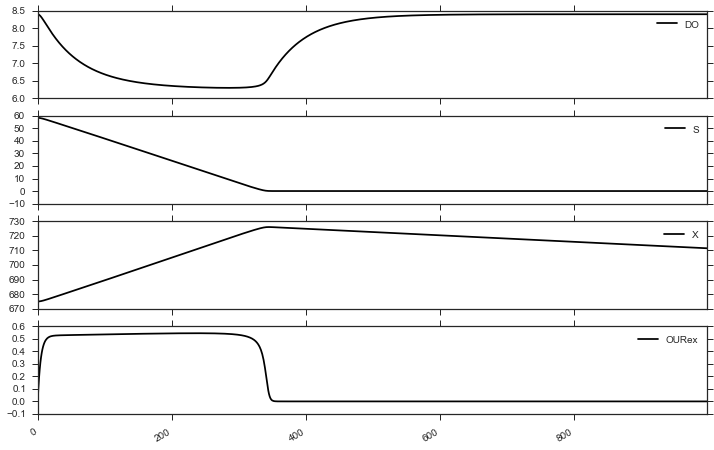

In [5]:
system = {'dS': '-(1. - exp(-t/tau))*(1/Y)*mu_max*S/(S+K_S)*X',
          'dX': '(1. - exp(-t/tau))*(1/Y)*mu_max*S/(S+K_S)*X - b*X',
          'dDO': '369.73*(8.4-DO)-((1-Y)/Y)*(1.0 - exp(-t/tau))*mu_max*S/(S+K_S)*X',
          'OURex': '((1.- exp(-t/tau))*mu_max*(1-Y)/Y*S/(S+K_S)*X)/(24.*60.)'}

parameters = {'mu_max': 4., 'K_S': 0.4, 'b': 0.62, 'Y': 0.78,
              'tau':2.25e-04}

timestepping = np.linspace(0, 0.05, 1000)
respiro_model = Model('Respirometry', system, parameters)
respiro_model.set_independent({'t': timestepping})
respiro_model.set_initial({'S': 58.48, 'X': 675, 'DO':8.4})

respiro_model.initialize_model()
output = respiro_model.run()
axs = output.plot(subplots=True, figsize=(12, 8))
output.index = timestepping

### Reading in the observations

In [6]:
observations = pd.read_csv("respirometer_data.txt", sep="\t", index_col=0, 
                           names=["DO", "OURex"], skiprows=2)
observations.index = observations.index/(60*24)  #everything to days
observations.index.name='t'

In [7]:
observations.head()

,DO,OURex
t,,
0.000000,8.488234,0.006513
0.000010,8.488691,0.022208
0.000022,8.493058,0.037903
0.000035,8.495394,0.053598
0.000046,8.492392,0.069293


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f63a1fe1590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f639fc7fb50>], dtype=object)

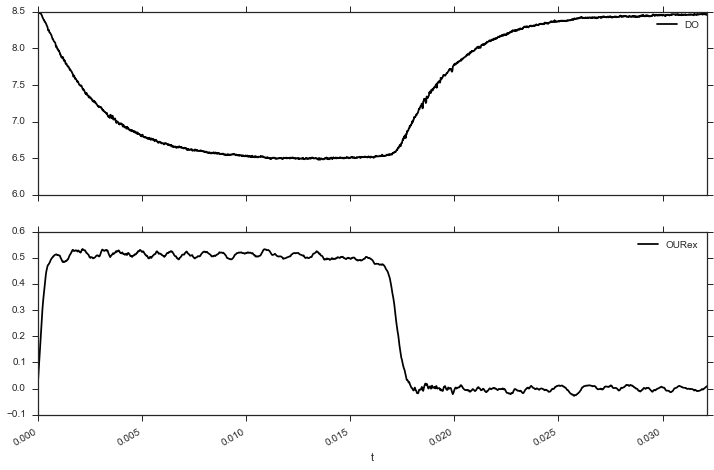

In [8]:
observations.plot(subplots=True, figsize=(12, 8))

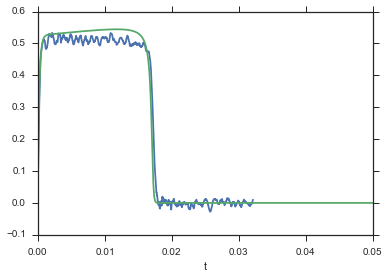

In [9]:
observations["OURex"].plot()
output["OURex"].plot()

### Confronting the measurements and the model in the optimization class:

Focusing on the OUR measurements only:

In [10]:
respiro_data = ode_measurements(pd.DataFrame(observations["OURex"]))

Adding a relative measurement error for the measurements (based on the noise of the measurement):

In [11]:
respiro_data.add_measured_errors({'OURex': 0.01})

We assume that only the kinetic parameters are uncertain and need to be estimated:

In [12]:
respiro_optim = ParameterOptimisation(respiro_model, respiro_data, optim_par=['mu_max','K_S'])

Running a local optimization (actually maximuma likelihood special case situation):

In [17]:
respiro_optim.local_optimize(pardict={'mu_max':2., 'K_S':0.6}, obj_crit='wsse', method='Nelder-Mead')

  status: 0
    nfev: 105
 success: True
     fun: 27439935.680532862
       x: array([  9.45216663e-06,   1.12085567e+00])
 message: 'Optimization terminated successfully.'
     nit: 57

In [19]:
mumax_es = np.random.uniform(1.0, 4., N)
K_s_es = np.random.uniform(0.1, 0.8, N)

In [66]:
# explore the parameter space
N = 5000
mumax_es = np.random.uniform(3.86, 4., N)
K_s_es = np.random.uniform(0.3, 0.5, N)
parameters = np.concatenate((np.atleast_2d(mumax_es), np.atleast_2d(K_s_es)), axis=0).transpose()
SSE = np.zeros(N)
for j in range(N):
    mu_max, K_S = parameters[j,  :]
    residuals = respiro_optim._run_model(dof_array=np.array([mu_max, K_S]))["OURex"] - \
                                respiro_optim.measurements.Data["OURex"]
    SSE[j] = sum(residuals**2)

<matplotlib.colorbar.Colorbar instance at 0x7f639d8b0dd0>

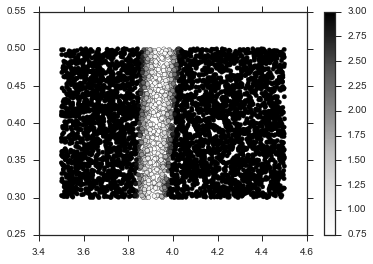

In [46]:
axs.set_ylim(0.3, 0.5)
axs.set_xlim(3.86, 4.)

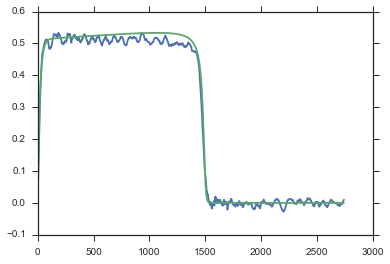

In [14]:
plt.plot(respiro_optim.modmeas["Measured"]["OURex"])
plt.plot(respiro_optim.modmeas["Modelled"]["OURex"])

In [15]:
respiro_optim.dof

['mu_max', 'K_S']

In [15]:
myrun = respiro_optim._run_model(dof_array=np.array([3.9, 0.4]))

In [49]:
#myrun

### using pyIDEAS in emcee Hammer

In [17]:
import emcee

In [31]:
def respiro_get_residuals(parameters):
    """run respiromodel and calculate the residuals as a numpy.array
    """
    mu_max, K_S = parameters
    residuals = respiro_optim._run_model(dof_array=np.array([mu_max, K_S]))["OURex"] - \
                                respiro_optim.measurements.Data["OURex"]
    return residuals.values

In [19]:
respiro_get_residuals([3.9, 0.4])

array([-0.00651276,  0.00072707,  0.00955954, ..., -0.00864222,
       -0.00939906, -0.01015596])

In [20]:
def lnprior(parameters):
    mu_max, K_S = parameters
    if 3.5 < mu_max < 4.5 and 0.3 < K_S < 0.5:
        return 0.0
    return -np.inf

In [21]:
# gaussian, geen meetfout,...
def lnlike(parameters):
    residuals = respiro_get_residuals(parameters)
    observed = respiro_optim.measurements.Data["OURex"].values
    N = len(observed)
    sigma2 = np.std(observed)**2.
    loglike = -N*np.log(2*np.pi)/2. - N*np.log(sigma2)/2. - ((residuals)**2).sum()/(2*sigma2)
    return loglike

In [22]:
def lnprob(parameters):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(parameters)

In [23]:
ndim, nwalkers = 2, 100
pos = [[3.9, 0.32] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [24]:
respiro_optim.measurements.Data["OURex"].values

array([ 0.00651276,  0.02220774,  0.03790266, ...,  0.00864222,
        0.00939906,  0.01015596])

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampl_out = sampler.run_mcmc(pos, 500)

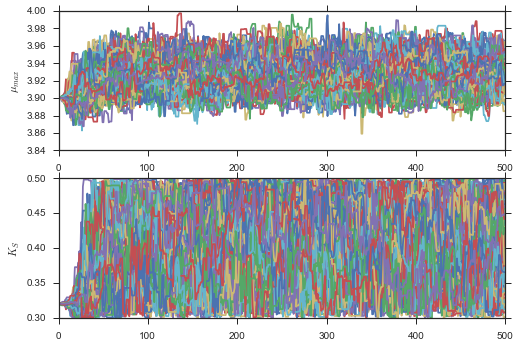

In [26]:
fig, ax =plt.subplots(2, 1)
for i in range(100):
    ax[0].plot(sampler.chain[i, :, 0])
    ax[1].plot(sampler.chain[i, :, 1])
ax[0].set_ylabel(r'$\mu_{max}$')
ax[1].set_ylabel(r'$K_S$')

In [29]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

In [73]:
import corner

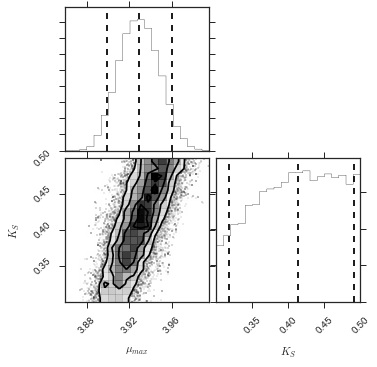

In [48]:
import corner
fig = corner.corner(samples, labels=["$\mu_{max}$", "$K_S$"], 
                    quantiles=[0.05, 0.5,0.95])

Analogie met de informal Bayesian Monte Carlo Filtering (Regional Sensitivity Analysis/GLUE):

(3.86, 4.0)

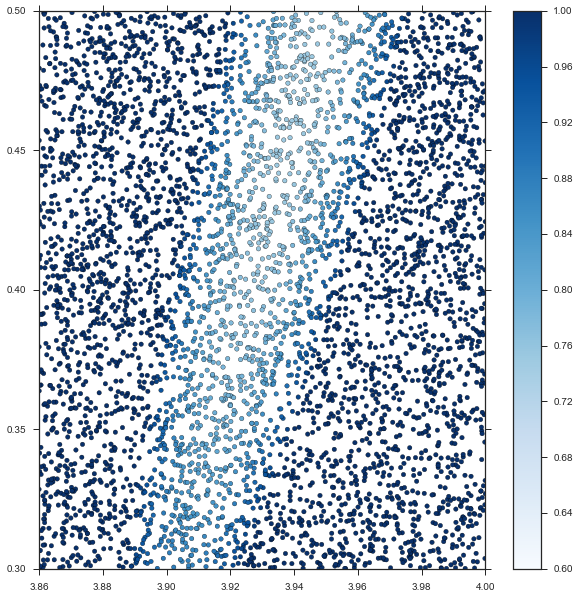

In [67]:
fig, axs = plt.subplots(figsize=(10,10))
scat = axs.scatter(mumax_es, K_s_es, c=SSE, vmax=1., vmin=0.6, cmap='Blues')
fig.colorbar(scat)
axs.set_ylim(0.3, 0.5)
axs.set_xlim(3.86, 4.)

In [85]:
limit = 1.5
behav_mumax = mumax_es[SSE < limit]
behav_K_s = K_s_es[SSE < limit]
SSE_behav = SSE[SSE < limit]

In [86]:
par_behav = np.concatenate((np.atleast_2d(behav_mumax), np.atleast_2d(behav_K_s)), axis=0).transpose()

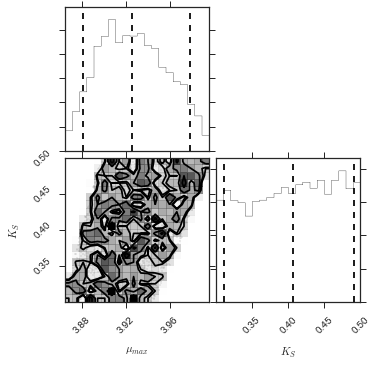

In [87]:
fig = corner.corner(par_behav, labels=["$\mu_{max}$", "$K_S$"], 
                    quantiles=[0.05, 0.5,0.95])